<center><image src="https://drive.google.com/uc?id=1n3G4TdK_u6PQHcLrxB_A0HijNdigXmUH">

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Домашнее задание можно разделить на следующие части:

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]
* Мир других лоссов! [2]
  * Dice Loss [1]
  * Focal Loss [1]
  * BONUS: лосс из статьи [5]
* Новая модель! [2]
  * UNet [2]


**Максимальный балл:** 10 баллов.

Также для студентов желающих еще более углубиться в задачу предлагается решить бонусное задание, которое даст дополнительные 5 баллов. BONUS задание необязательное.


# Шаг 1. Загрузка и подготовка данных

1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>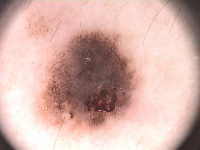</td><td>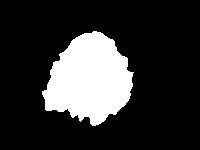</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [ ]:
!gdown 1izHli46krMamcDToFXFhV_cjoPAZbAdP

Downloading...
From (original): https://drive.google.com/uc?id=1izHli46krMamcDToFXFhV_cjoPAZbAdP
From (redirected): https://drive.google.com/uc?id=1izHli46krMamcDToFXFhV_cjoPAZbAdP&confirm=t&uuid=2f3ab402-7024-45da-b9f8-1e6908ede3c1
To: /content/PH2Dataset.rar
100% 162M/162M [00:00<00:00, 165MB/s]


In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

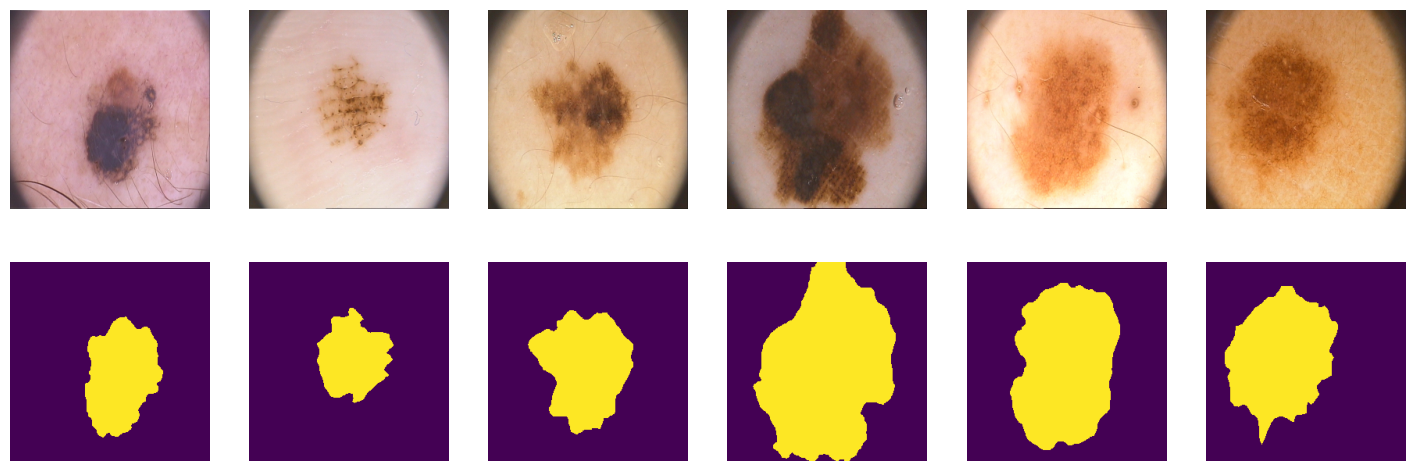

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


## PyTorch DataLoader

In [ ]:
from torch.utils.data import DataLoader
batch_size = 25
train_dataloader = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=False)

In [ ]:
loaders = {'train':train_dataloader, 'val': valid_dataloader}

In [ ]:
import torch
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)

In [ ]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Шаг 2. Метрика качества модели

## IoU (intersection over union)

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Что будет являться пересением и объединением в задаче сегментации?

Давайте разберем следующий пример:





<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1rBYFgli48AUUN9idiyq8j3J5DboB93yN" width=1000 height=800/></p>

In [ ]:
!pip install -q torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 32.6 MB/s eta 0:00:00


In [ ]:
from torchmetrics import JaccardIndex

iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(DEVICE)

# Задания: Построй свой первый бейзлайн!

Итак, загрузка файлов, код датасета и даталоадера написана за вас. Метрика IoU написана за вас! Вам остается написать лосс, модель и функции обучения и теста модели.

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]

## Шаг 3. Loss функция - BCE [2 балла]

Популярным лоссом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

### Вывод численно стабильной формулы BCE лосса [1 балл]



Выведите из формулы [1] формулу [2]:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

Не забываем, что здесь $\hat y_i$ - это логиты сети, не вероятности и не лейблы.

**Ответ:**

$$\mathcal \log\sigma(\hat y_i) = \log\frac{1}{1+e^{-\hat y_i}}=\log1 - \log(1+e^{-\hat y_i}) = - \log(1+e^{-\hat y_i})$$

$$\mathcal \log(1 - \sigma(\hat y_i)) = \log(1 - \frac{1}{1+e^{-\hat y_i}}) = \log\frac{e^{-\hat y_i}}{1+e^{-\hat y_i}} = \log(e^{-\hat y_i}) - \log(1+e^{-\hat y_i}) = {-\hat y_i} - \log(1+e^{-\hat y_i})$$

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] = - \sum_i \left[y_i( - \log(1+e^{-\hat y_i})) + (1-y_i)({-\hat y_i} - \log(1+e^{-\hat y_i}))\right]=- \sum_i \left[-y_i \log(1+e^{-\hat y_i}) -{\hat y_i} - \log(1+e^{-\hat y_i}) + y_i{\hat y_i} + y_i \log(1+e^{-\hat y_i})\right] = \sum_i \left[{\hat y_i} - y_i{\hat y_i} + \log(1+e^{-\hat y_i}) \right]$$

### Реализуйте в коде оба варианта лосса [1 балл]

Реализуйте следующие функции:

*   `bce_true()` - честная прямая реализация лосса с формулой $$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$
*   `bce_loss()` - реализация формулы, которую мы вывели $$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

И сравните результаты функций с реализацией Pytorch:
*   `bce_torch()`
*   `bce_torch_with_logits()`

In [ ]:
import torch.nn.functional as F
import torch.nn as nn

In [ ]:
bce_torch = nn.BCELoss(reduction='sum') # (sigmoid(y_pred), y_real)
bce_torch_with_logits = nn.BCEWithLogitsLoss(reduction='sum')

In [ ]:
def bce_loss(y_pred, y_real):
  return torch.sum(y_pred - y_pred*y_real + torch.log(1 + torch.exp(-y_pred)))

def bce_true(y_pred, y_real):
  y = y_real
  p = 1 / (1 + torch.exp(-y_pred))
  return -torch.sum(y * torch.log(p) + (1 - y) * torch.log(1 - p))

Проверим корректность работы на простом примере

In [ ]:
y_pred = torch.randn(3, 2, requires_grad=False)
y_true = torch.rand(3, 2, requires_grad=False)

print(f'BCE loss from scratch bce_loss             = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный                = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch              = {bce_torch(torch.sigmoid(y_pred), y_true)}')
print(f'BCE loss from torch with logits bce_torch  = {bce_torch_with_logits(y_pred, y_true)}')


BCE loss from scratch bce_loss             = 4.616026401519775
BCE loss честно посчитанный                = 4.616025924682617
BCE loss from torch bce_torch              = 4.616025924682617
BCE loss from torch with logits bce_torch  = 4.616025924682617


Инструкции `assert` в Python — это булевы выражения, которые проверяют, является ли условие истинным (`True`). Внизу в коде мы проверяем функция `bce_loss()` выдает тот же результат, что и функция из Pytorch или нет. Если равенства не будет, что будет означать, что результаты функций не совпадают, а значит вы неправильно реализовали фукнцию `bce_loss()`, `assert` возвратит ошибку.

Функция `numpy.isclose()` используется для сравнения двух чисел с учётом допустимой погрешности. Она особенно полезна при работе с числами с плавающей точкой, где точное сравнение может быть проблематичным из-за ограничений представления таких чисел в компьютере.

Как она работает?

`numpy.isclose(a, b, rtol=1e-05, atol=1e-08) `принимает два числа (`a` и `b`) и сравнивает их, учитывая относительную и абсолютную погрешность. Если разница между двумя числами меньше заданного порога, функция возвращает `True`, иначе — `False`.

Параметры:

    rtol: Относительная погрешность (по умолчанию 1e-05). Используется для определения разницы относительно большего значения.
    atol: Абсолютная погрешность (по умолчанию 1e-08). Определяет минимальную разницу, которую следует учитывать.

Мы будем использовать `assert` и `numpy.isclose()` для проверки корректности нашего кода.

In [ ]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))

Давайте теперь посчитаем на простом примере, но с теми же размерностями, что и в датасете

In [ ]:
y_pred = torch.randn((2, 1, 3, 3), requires_grad=False)
y_true = torch.randint(0, 2, (2, 1, 3, 3))

print(f'BCE loss from scratch bce_loss            = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный               = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch             = {bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float))}')
print(f'BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true.to(torch.float))}')

BCE loss from scratch bce_loss            = 14.737800598144531
BCE loss честно посчитанный               = 14.737801551818848
BCE loss from torch bce_torch             = 14.737801551818848
BCE loss from torch with logits bce_torch = 14.737800598144531


In [ ]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))

Давайте посчитаем на реальных логитах и сегментационной маске:

In [ ]:
!gdown --folder 1EX0RW1TRQVkLmR1h6miCQqyhYPFyg28M

Retrieving folder contents
Processing file 1--WxvBdpMn_NOmYPf3a4au8MHzfx5baC labels.pt
Processing file 1-0A7_CS_vKiSCkgIDJ4joThCEcFedA3I logits.pt
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1--WxvBdpMn_NOmYPf3a4au8MHzfx5baC
To: /content/for_asserts/labels.pt
100% 1.18k/1.18k [00:00<00:00, 7.50MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-0A7_CS_vKiSCkgIDJ4joThCEcFedA3I
To: /content/for_asserts/logits.pt
100% 1.18k/1.18k [00:00<00:00, 6.79MB/s]
Download completed


In [ ]:
path_to_dummy_samples = '/content/for_asserts'
dummpy_sample = {'logits': torch.load(f'{path_to_dummy_samples}/logits.pt'),
                 'labels': torch.load(f'{path_to_dummy_samples}/labels.pt')}
dummpy_sample['labels'] = dummpy_sample['labels'].to(DEVICE)
dummpy_sample['logits'] = dummpy_sample['logits'].to(DEVICE)

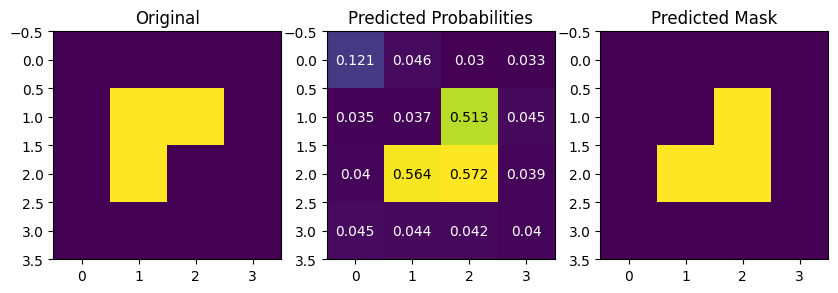

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize= (10,3*10))

ax1.imshow(dummpy_sample['labels'].squeeze(1)[0].cpu())
ax1.set_title("Original")

ax2.imshow(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu())
for (j,i),label in np.ndenumerate(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu()):
    if label < 0.5:
        color = 'white'
    else:
        color = 'black'
    ax2.text(i,j,round(label,3), color=color, ha='center',va='center')

ax2.set_title("Predicted Probabilities")

ax3.imshow((dummpy_sample['logits'].sigmoid() > 0.5).squeeze(1)[0].cpu())
ax3.set_title("Predicted Mask")
plt.show()

Проверяем на данном примере:

In [ ]:
bce_loss_score = bce_loss(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_true_score = bce_true(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_torch_score = bce_torch(torch.sigmoid(dummpy_sample['logits'].cpu()), dummpy_sample['labels'].cpu().float())
bce_torch_with_logits_score = bce_torch_with_logits(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu().float())
assert np.isclose(bce_loss_score, bce_torch_score)
assert np.isclose(bce_loss_score, bce_torch_with_logits_score)
assert np.isclose(bce_true_score, bce_torch_score)
assert np.isclose(bce_true_score, bce_torch_with_logits_score)

## Шаг 4. Модель SegNet [2 балла]

Ваше задание здесь состоит в том, чтобы реализовать SegNet архитектуру.

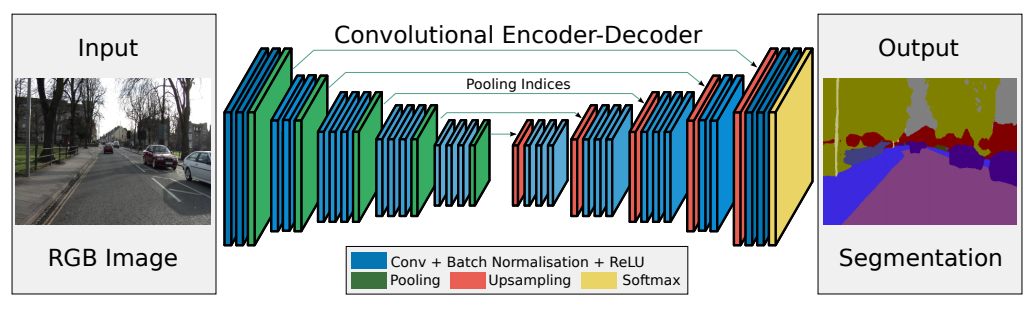

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки. Для этого скачаем и изучим feature extractor VGG-16, который лежит в основе SegNet.

In [ ]:
model_vgg16 = models.vgg16(weights = models.VGG16_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:07<00:00, 71.5MB/s]


In [ ]:
model_vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Feature extractor VGG-16 состоит из 5 блоков:
- два блока со структурой:
Conv2d -> ReLU -> Conv2d -> ReLU -> MaxPool2d
- три блока со структурой:
Conv2d -> ReLU -> Conv2d -> ReLU -> Conv2d -> ReLU -> MaxPool2d

В первом блоке - на входе три канала (по числу каналов в изображениях), которые конволюционный слой преобразует в 64 канала.

Во втором, третьем и четвертом блоках первый конволюционный слой удваивает количество каналов, а последующие конволюционные слои не меняют количество каналов.

В последнем блоке число каналов от слоя к слою не меняется.

Теперь напишем код одного блока энкодера нашей модели SegNet.  

In [ ]:
# Параметрами блока будут:
# - количество каналов на входе
# - количество каналов на выходе
# - глубина блока (2 или 3, по количеству конволюционных слоев)
# - kernel_size и padding
#
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, depth, kernel_size = 3, padding = 1):
        super(EncoderBlock, self).__init__() # инициируем экземляр класса, наследующего от nn.Module
        self.layers = nn.ModuleList() # в self.layers будем добавлять слои блока
        # дальше реализуем то, что на картинке выше обозначено Conv + Batch Normalization + ReLU
        self.layers.append(nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size, padding = padding))
        self.layers.append(nn.BatchNorm2d(out_channels))
        self.layers.append(nn.ReLU(inplace=True))

        # цикл for помогает использовать один код для блоков как с глубиной 2, так и с глубиной 3
        for i in range(depth-1):
            self.layers.append(nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size = kernel_size, padding = padding))
            self.layers.append(nn.BatchNorm2d(out_channels))
            self.layers.append(nn.ReLU(inplace=True))

        self.maxpooling = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) #добавляем MaxPool с индексами для последующего Unpooling

    # Обратите внимание: на вход метод forward() получает карту признаков (х),
    # а возвращает карту признаков и индексы для последующего Unpooling
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        size = x.size()
        x, indices = self.maxpooling(x)
        return x, indices, size


По аналогии напишите код одного блока декодера.

К карте признаков на входе каждого блока примеяется nn.MaxUnpool2d с индексами из симметричного блока энкодера. Затем повторяется связка Conv + Batch Normalization + ReLU. Количество каналов меняется зеркально блокам энкодера:
- в первом блоке декодера количество каналов не меняется
- во 2-4 блоках декодера количество каналов уменьшается в 2 раза после прохождения последнего конволюционного слоя
- на выходе из последнего блока декодера 1 канал

Обратите внимание, что после последней конволюции последнего блока декодера не применяется батч-нормализация и функция активации.

In [ ]:
class DecoderBlock(nn.Module):
  def __init__(self, in_channels, out_channels, depth, kernel_size = 3, padding = 1):
    super().__init__()

    # число каналов уменьшается в последнем слое блока

    self.layers = nn.ModuleList()

    for i in range(depth-1):
      self.layers.append(nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=kernel_size, padding=padding))
      self.layers.append(nn.BatchNorm2d(in_channels))
      self.layers.append(nn.ReLU(inplace=True))

    self.layers.append(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding))
    self.layers.append(nn.BatchNorm2d(out_channels))
    self.layers.append(nn.ReLU(inplace=True))

    self.maxunpooling = nn.MaxUnpool2d(kernel_size=2, stride=2)

  def forward(self, x, indices, output_size):
    x = self.maxunpooling(x, indices, output_size)

    for layer in self.layers:
      x = layer(x)
    return x


Соединим блоки энкодера и декодера в модель SegNet:

In [ ]:
class SegNet(nn.Module):
    def __init__(self, in_channels=3, out_channels = 1, num_features = 64) -> None:
        super(SegNet, self).__init__()

        # Encoder
        self.encoder0 = EncoderBlock(in_channels, num_features, depth=2)
        self.encoder1 = EncoderBlock(num_features, num_features * 2, depth=2)
        self.encoder2 = EncoderBlock(num_features * 2, num_features * 4, depth=3)
        self.encoder3 = EncoderBlock(num_features * 4, num_features * 8, depth=3)

        # Encoder bottleneck - количество каналов на входе и на выходе одинаково
        self.encoder4 = EncoderBlock(num_features * 8, num_features * 8, depth=3)

        # Decoder bottleneck
        self.decoder0 = DecoderBlock(num_features * 8, num_features * 8, depth=3)

        # Decoder
        self.decoder1 = DecoderBlock(num_features * 8, num_features * 4, depth=3)
        self.decoder2 = DecoderBlock(num_features * 4, num_features * 2, depth=3)
        self.decoder3 = DecoderBlock(num_features * 2, num_features, depth=2)
        self.decoder4 = DecoderBlock(num_features, num_features, depth=2)
        self.final = nn.Conv2d(num_features, out_channels, kernel_size=1)

    def forward(self, x):
        # encoder
        e0, ind0, size0 = self.encoder0(x)
        e1, ind1, size1 = self.encoder1(e0)
        e2, ind2, size2 = self.encoder2(e1)
        e3, ind3, size3 = self.encoder3(e2)
        e4, ind4, size4 = self.encoder4(e3)

        # Decoder
        d0 = self.decoder0(e4, ind4, size4)
        d1 = self.decoder1(d0, ind3, size3)
        d2 = self.decoder2(d1, ind2, size2)
        d3 = self.decoder3(d2, ind1, size1)
        d4 = self.decoder4(d3, ind0, size0)
        output = self.final(d4)
        return output  # no activation

## Шаг 5. Тренировка модели [1 балл]

Напишите функции для обучения модели.

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
def fit_one_epoch(model, train_dataloader, optimizer, loss_func):
  '''
  args:
    model - модель для обучения
    train_dataloader - loader с выборкой для обучения модели
    optimizer - оптимизатор, взятый из модуля `torch.optim`
    loss_func - функция потерь, взятая из модуля `torch.nn`

  функция возвращает метрику accuracy по эпохе на данных из train_dataloader
  '''

  model.train()
  avg_loss = 0
  visualized = False

  for X_batch, y_batch in tqdm(train_dataloader):
    X_batch = X_batch.to(DEVICE)
    y_batch = y_batch.to(DEVICE)

    optimizer.zero_grad()
    outp = model(X_batch)

    prob = torch.sigmoid(outp)
    y_pred = (prob > 0.5).long()
    if not visualized:
      visualized = True
      visualize(X_batch, y_batch, y_pred)

    loss = loss_func(outp, y_batch)
    loss.backward()
    optimizer.step()

    avg_loss += loss.item()

  return avg_loss / len(train_dataloader)

In [ ]:
def eval_one_epoch(model, val_dataloader, loss_func):
  '''
  args:
    model - модель для обучения
    val_dataloader - loader с валидационной/тестовой выборкой
  '''
  iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(DEVICE)

  model.eval()
  avg_loss = 0
  avg_iou = 0

  visualized = False

  with torch.no_grad():
    for X_batch, y_batch in tqdm(val_dataloader):
      X_batch = X_batch.to(DEVICE)
      y_batch = y_batch.to(DEVICE)

      outp = model(X_batch)
      prob = torch.sigmoid(outp)
      y_pred = (prob > 0.5).long()

      loss = loss_func(outp, y_batch)
      iou = iou_score(y_pred, y_batch)

      avg_loss += loss.item()
      avg_iou += iou.cpu().item()

      if not visualized:
        visualized = True
        visualize(X_batch, y_batch, y_pred)

    avg_loss = avg_loss / len(val_dataloader)
    avg_iou = avg_iou / len(val_dataloader)

  return avg_loss, avg_iou

In [ ]:
def visualize(X_batch, y_batch, pred, n=1):
  batch_size = X_batch.shape[0]

  plt.figure(figsize=(10, 3*n))
  for i in range(n):
    img = X_batch[i].permute(1,2,0).cpu().numpy()
    true_mask = y_batch[i].cpu().squeeze().numpy()
    pred_mask = pred[i].squeeze().cpu().numpy()

    plt.subplot(n, 3, i*3 + 1)
    plt.title("Image")
    plt.imshow(img)
    plt.axis("off")

    plt.subplot(n, 3, i*3 + 2)
    plt.title("GT mask")
    plt.imshow(true_mask, cmap="nipy_spectral")
    plt.axis("off")

    plt.subplot(n, 3, i*3 + 3)
    plt.title("Pred mask")
    plt.imshow(pred_mask, cmap="nipy_spectral")
    plt.axis("off")

  plt.show()

In [ ]:
def train_func(model, num_epochs, dataloaders, optimizer, loss_func):
  '''
  args:
    model - модель для обучения
    num_epochs - количество эпох
    dataloaders - словарь loader'ов с обучающей и валидационной выборками
    optimizer - оптимизатор, взятый из модуля `torch.optim`
    loss_func - функция потерь, взятая из модуля `torch.nn`

  функция возвращает loss на обучающей и валидационной выборках на каждой эпохе, а также метрику IoU на валидационной выборке
  '''
  model = model.to(DEVICE)
  score = {"train_loss": [], "val_loss": [], "val_iou": []}
  for epoch in range(num_epochs):
    print(f"\nEpoch: {epoch+1}")

    loss_train = fit_one_epoch(model = model, train_dataloader = dataloaders['train'], optimizer = optimizer, loss_func = loss_func)
    print(f"Loss train: {loss_train}\n")

    loss_val, iou_val = eval_one_epoch(model = model, val_dataloader = dataloaders['val'], loss_func=loss_func)
    print(f"Loss valid: {loss_val}\n")
    print(f"IoU valid: {iou_val}\n")


    score['train_loss'].append(loss_train)
    score['val_loss'].append(loss_val)
    score['val_iou'].append(iou_val)
  return model, score

Обучите модель **SegNet**. В качестве оптимайзера можно взять Adam.

In [ ]:
model_baseline = SegNet()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_baseline.parameters(), lr = 1e-3)
model_baseline, score_baseline = train_func(model_baseline, 50, loaders, optimizer, criterion)

## Шаг 6. Инференс [1 балл]

После обучения модели напишите функцию теста, воспользуйтесь лучшим чекпоинтом и протестируйте работу модели на тестовой выборке.

In [ ]:
def test(model, test_dataloader):
  model.eval()

  iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(DEVICE)
  avg_iou = 0
  with torch.no_grad():
    for X_batch, Y_batch in test_dataloader:
      X_batch = X_batch.to(DEVICE)
      Y_batch = Y_batch.to(DEVICE)

      outp = model(X_batch)
      prob = torch.sigmoid(outp)
      y_pred = (prob > 0.5).long()
      avg_iou += iou_score(y_pred, Y_batch)

  return avg_iou / len(test_dataloader)

In [ ]:
test_score = test(model_baseline, test_dataloader)

In [ ]:
test_score.item()

0.8155158758163452

# Задания: Мир других лоссов!

## Пробуем другие функции потерь [2 балла]

В данном разделе вам потребуется имплементировать две функции потерь: DICE и Focal loss.


### Dice Loss

**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

В терминах матрицы ошибок она будет считаться следующим образом:

$$D(X,Y) = \frac{2TP}{2TP + FP + FN}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1- D(X, Y)$$

**Hints** (!):

1. Не забудьте подумать о численной нестабильности, возникающей в математической формуле при ситуации, когда $\frac{0}{0}$, т.е. вам нужно добавить очень маленькое число, например $\epsilon = 1e^{-8}$, в обе части дроби при подсчете $D(X,Y)$:

$$D(X,Y) = \frac{2TP + ϵ}{2TP + FP + FN + ϵ}$$

2. Dice метрика(!), не лосс, считается похожим образом как IoU:

    2.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    2.2. Фиксируем порог, например threshold=0.5, и всему что ниже порога ставим значение 0, всему что выше 1. Получаем предсказанную маску из 0 и 1.

    2.3. Считаем TP, FP, FN

    2.4. Считаем DICE метрику по формуле

Вы можете прописать для себя функцию `dice_score()` и сравнить с результатами работы функции из библиотеки `torchmetrics`.

3. Но с метрикой есть проблема, что она не дифференцируема, и если вы захотите просто взять и прописать `dice_loss` = 1 - `dice_score`, Pytorch поругается на вас и скажет, что это недифференцируемая метрика. Чтобы посчитать dice_loss делаем следующие шаги:

    3.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    3.2. Здесь нам уже не нужно фиксировать порог, мы просто работаем с вероятностями. Значения вероятностей дифференцируемы и через них будут протекать градиенты.

    3.3. Считаем TP, FP, FN также как и в Dice метрике, только вместо маски, подаем вероятности.

    3.4. Считаем DICE метрику по формуле

    3.5. Считаем лосс как Loss = 1 - DICE

Итак, давайте сначала пропишем dice_score.

In [ ]:
def dice_score(logits: torch.Tensor, labels: torch.Tensor, threshold: float = 0.5):
  '''
  Это именно метрика, не лосс.
  '''
  eps = 1e-8

  prob = torch.sigmoid(logits)
  preds = (prob > threshold).int()

  TP = (preds * labels).sum()
  FP = (preds * (1 - labels)).sum()
  FN = ((1 - preds) * labels).sum()

  score = (2 * TP + eps) / (2 * TP + FP + FN + eps)

  return score

Проверим на корректность функцию dice_score:

In [ ]:
from torchmetrics.segmentation import DiceScore

dice = DiceScore(num_classes=1, average='micro').to(DEVICE)
dice(dummpy_sample['logits'].sigmoid() > 0.5, dummpy_sample['labels'].int())

/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: DiceScore metric currently defaults to `average=micro`, but will change to`average=macro` in the v1.9 release. If you've explicitly set this parameter, you can ignore this warning.
  warnings.warn(*args, **kwargs)


tensor(0.6667, device='cuda:0')

In [ ]:
assert dice(dummpy_sample['logits'].sigmoid()>0.5, dummpy_sample['labels'].to(int)) == dice_score(dummpy_sample['logits'], dummpy_sample['labels'])

Давайте теперь пропишем лосс и воспользуемся библиотекой `segmentation-models-pytorch`, чтобы убедиться в корректности нашей функции.

In [ ]:
def dice_loss(logits: torch.Tensor, labels: torch.Tensor):
  eps = 1e-8

  probs = torch.sigmoid(logits)

  TP = (probs * labels).sum()
  FP = (probs * (1 - labels)).sum()
  FN = ((1 - probs) * labels).sum()

  dice = (2 * TP + eps) / (2 * TP + FP + FN + eps)
  return 1 - dice.mean()

Проверка на корректность:

In [ ]:
# проверьте, что у вас установлена библиотека
!pip install -q segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.5 MB/s eta 0:00:00


In [ ]:
from segmentation_models_pytorch.losses import DiceLoss
dice_loss_torch = DiceLoss(mode='binary')
dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'])

tensor(0.5756, device='cuda:0')

In [ ]:
dice_loss(dummpy_sample['logits'], dummpy_sample['labels'])

tensor(0.5756, device='cuda:0')

In [ ]:
assert dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'].to(int)) == dice_loss(dummpy_sample['logits'], dummpy_sample['labels'])

### Focal Loss

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.


Из оригинальной статьи по [Focal Loss](https://arxiv.org/pdf/1708.02002.pdf):

$$p_t = \sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)$$

$$\mathcal L_{focal}(y, \hat y) = (1 - p_t)^{\gamma} \mathcal L_{BCE}(y_i, \hat y_i).$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - p_t)^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - (\sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)))^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

In [ ]:
def focal_loss(y_real, y_pred, eps = 1e-6, gamma = 2):
  p = torch.sigmoid(y_pred) * y_real + (1 - torch.sigmoid(y_pred))*(1 - y_real)
  bce_loss = -(y_real * torch.log(torch.sigmoid(y_pred) + eps) + (1 - y_real) * torch.log(1 - torch.sigmoid(y_pred) + eps))
  loss = (1 - p)**gamma * bce_loss
  return loss.sum()

Проверка корректности функции:

In [ ]:
from torchvision.ops import sigmoid_focal_loss
sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum').item()

3.616123676300049

In [ ]:
assert torch.allclose(sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum'),
                      focal_loss(dummpy_sample['labels'], dummpy_sample['logits'], gamma=2.0),
                      rtol=1e-5,
                      atol=1e-8)

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее, и провести численное сравнение с предыдущими функциями.

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Для изучения была выбрана статья [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

Основная идея ***Structural Similarity Loss***:

Вместо того, чтобы смотреть на соответствие единичных пикселей, которые в свою очередь игнорируют зависимость между друг другом, этот метод предлагает смотреть, насколько коррелированы разные локальные участки предсказанной карты сегментации и истинной, и уделять внимание позициям, чьи предсказания приводят к низкой степени линейной корреляции.

Для реализации этой идеи авторы предлагают рассмотреть сумму обычной BCE loss и перевзвешинной BCE loss. К перевзвешенной при этом добавляют множитель ошибки - меру структурного сходства. Также для участков с маленькой ошибкой, перевзвешенная BCE loss будет зануляться, как бы предполагая, что на них все достаточно хорошо и ничего не нужно менять.



Для реализации этой функции потерь нужны следующие формулы:

Общая целевая функция:

$$
L_{all}(y, p) = \lambda L_{ce}(y, p) + (1-\lambda) L_{ssl}(y, p) \tag{17}
$$

Классическая кросс-энтропия

$$
L_{ce}(y, p) = - \frac{1}{N} \sum_{n=1}^N \sum_{c=1}^C y_{n,c} \log(p_{n,c}) \tag{1}
$$

$e$ — это общая абсолютная ошибка между стандартизованными нормализованными результатами истинных значений ($y$) и предсказаний ($p$). Это мера структурного различия (обратная корреляции). $C_4 = 0.01$ — стабилизирующий фактор.

$$
e = \left|\frac{y - \mu_y + C_4}{\sigma_y + C_4} - \frac{p - \mu_p + C_4}{\sigma_p + C_4}\right| \tag{10}
$$

Маска для выбора примеров отбрасывает «легкие примеры» (те, для которых $e$ мало), тем самым реализуя стратегию Online Hard Example Mining (OHEM).

$$
f_{n,c} = 1_{\{e_{n,c} > \beta e_{\max}\}} \tag{11}
$$

$L_{ssl}$ — это сигмоидальная кросс-энтропия $L_{ce}$, перевзвешенная структурной ошибкой $e$ и умноженная на маску $f_{n,c}$. $e_{n,c}$ используется как постоянный весовой коэффициент.

$$
L_{ssl}(y_{n,c}, p_{n,c}) = e_{n,c} f_{n,c} L_{ce}(y_{n,c}, p_{n,c}) \tag{12}
$$

Итоговая функция потерь SSL по мини-батчу $L_{ssl}$ усредняется только по $M$ выбранным «трудным примерам».
$$
L_{ssl}(y, p) = \frac{1}{M} \sum_{n=1}^N \sum_{c=1}^C L_{ssl}(y_{n,c}, p_{n,c}) \tag{13}
$$

Для подсчета статистик необходимо будет пройтись гауссовым окном по картам сегментации.

Вспомогатльные формулы:

Локальное среднее:
$$
\mu_y = \sum_{i=1}^{k^2} w_i y_i \tag{14}
$$

Локальная дисперсия:
$$
\sigma^2_y = \sum_{i=1}^{k^2} w_i(y_i - \mu_y)^2 = \sum_{i=1}^{k^2} w_i y^2_i - \mu^2_y \tag{15}
$$



${w_i}$ - ${i}$ -тое значение в гауссовском окне (ядре)

In [ ]:
from typing import Tuple
import torch
import torch.nn.functional as F

In [ ]:
def make_gaussian_kernel(k: int, sigma: float):
  assert k % 2 == 1, "kernel size must be odd"
  half = k // 2
  xs = torch.arange(-half, half+1, dtype=torch.float32)
  ys = xs.view(-1, 1)
  kernel = torch.exp(-(xs**2 + ys**2) / (2 * sigma**2))
  kernel = kernel / kernel.sum()
  return kernel

In [ ]:
class BinaryStructuralSimilarityLoss(nn.Module):
  def __init__(self, window_size=3, tau=0.1, lambda_ce=0.9, c=0.01, eps=1e-8, gauss_sigma=1.5):
    super().__init__()
    self.k = window_size
    self.tau = tau
    self.lambda_ce = lambda_ce
    self.c = c
    self.eps = eps
    self.gauss_sigma = gauss_sigma

  def __get_kernel(self):
    kernel = make_gaussian_kernel(self.k, self.gauss_sigma)
    return kernel

  def count_abs_structural_error(self, probs: torch.Tensor, labels: torch.Tensor):
    B = probs.shape[0]
    p_unf, y_unf = self.make_patches(probs, labels) # (B, k*k, H*W)

    kernel = self.__get_kernel()

    statistics_p = self.compute_statistics_over_patch(probs, kernel) # (B,1,H,W)
    statistics_y = self.compute_statistics_over_patch(labels, kernel)

    mean_p, sigma_p = self.adjust_dims(statistics_p, B) # (B, k*k, H*W)
    mean_y, sigma_y = self.adjust_dims(statistics_y, B)

    z_p = (p_unf - mean_p + self.c) / (sigma_p + self.c)
    z_y = (y_unf - mean_y + self.c) / (sigma_y + self.c)

    error = torch.abs(z_y - z_p).sum(dim=1)  # (B, H*W)
    return error

  def make_patches(self, probs: torch.Tensor, labels: torch.Tensor):
    pad = self.k // 2
    p_unf = F.unfold(probs, kernel_size=self.k, padding=pad) # (B, k*k, H*W)
    l_unf = F.unfold(labels, kernel_size=self.k, padding=pad) # (B, k*k, H*W)

    return p_unf, l_unf

  def compute_statistics_over_patch(self, labels: torch.Tensor, kernel: torch.Tensor, eps: float = 1e-8):
    pad = self.k // 2
    kernel = kernel.view(1, 1, self.k, self.k).to(labels.device)

    mean = F.conv2d(labels, kernel, padding=pad)  # (B,1,H,W)
    E2 = F.conv2d(labels * labels, kernel, padding=pad)
    var = torch.clamp(E2 - mean * mean, min=0.0)
    sigma = torch.sqrt(var + eps)  # (B,1,H,W)

    return mean, sigma

  def adjust_dims(self, statistics: Tuple[torch.Tensor, torch.Tensor], num_batches: int):
    k = self.k
    B = num_batches
    mean_exp = statistics[0].view(B, 1, -1)  # (B, 1, H*W)
    sigma_exp = statistics[1].view(B, 1, -1)  # (B, 1, H*W)
    mean_exp = mean_exp.repeat(1, k*k, 1)  # (B, k*k, H*W)
    sigma_exp = sigma_exp.repeat(1, k*k, 1)
    return mean_exp, sigma_exp

  def forward(self, logits: torch.Tensor, labels: torch.Tensor):
    probs = torch.sigmoid(logits)
    error = self.count_abs_structural_error(probs, labels)
    indicator = (error > self.tau * error.max(dim=1, keepdim=True)[0]).float()

    bce_full = F.binary_cross_entropy_with_logits(logits, labels, reduction='mean')

    bce_pixel = F.binary_cross_entropy_with_logits(logits, labels, reduction='none').view(probs.shape[0], -1) # (B, H*W)
    L_ssl_pixel = error * indicator * bce_pixel # (B, H*W)

    M = indicator.sum(dim=1).clamp(min=1) # (B,)
    L_ssl_batch = (L_ssl_pixel.sum(dim=1) / M) # (B,)
    L_ssl = L_ssl_batch.mean()

    L_all = self.lambda_ce * bce_full + (1 - self.lambda_ce) * L_ssl
    return L_all


In [ ]:
ssloss = BinaryStructuralSimilarityLoss()
ssloss(dummpy_sample['logits'], dummpy_sample['labels']).item()

0.5462082028388977

Проведем численное сравнение с ранее использованными лоссами:

1. Рандомный пример

In [ ]:
logits = torch.tensor([[[[
    -1.,  1.,  2.,  1., -1.,
     1., -2., -3., -2.,  1.,
     2., -3., -4., -3.,  2.,
     1., -2., -3., -2.,  1.,
    -1.,  1.,  2.,  1., -1.,
]]]], dtype=torch.float32)

labels = torch.tensor([[[[
    0., 1., 1., 1., 0.,
    1., 0., 0., 0., 1.,
    1., 0., 0., 0., 1.,
    1., 0., 0., 0., 1.,
    0., 1., 1., 1., 0.,
]]]], dtype=torch.float32)



In [ ]:
print("SS Loss:", ssloss(logits, labels))
print("Dice Loss:", dice_loss(logits, labels))
print("Focal Loss:", focal_loss(logits, labels))
print("BCE Loss:", bce_loss(logits, labels))

SS Loss: tensor(0.2240)
Dice Loss: tensor(0.1897)
Focal Loss: tensor(2.3315)
BCE Loss: tensor(4.9871)


2. Пример с идеальным предсказанием

In [ ]:
labels = torch.tensor([[
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,1,1,1,1,0,0,0],
    [0,0,0,1,1,1,1,0,0,0],
    [0,0,0,1,1,1,1,0,0,0],
    [0,0,0,1,1,1,1,0,0,0],
    [0,0,0,1,1,1,1,0,0,0],
    [0,0,0,1,1,1,1,0,0,0],
    [0,0,0,1,1,1,1,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0]
]], dtype=torch.float)

logits = torch.where(labels==1, torch.tensor(10.0), torch.tensor(-10.0)).unsqueeze(0)
# shape: (1,1,10,10)
labels = labels.unsqueeze(0)


In [ ]:
print("SS Loss:", ssloss(logits, labels))
print("Dice Loss:", dice_loss(logits, labels))
print("Focal Loss:", focal_loss(logits, labels))
print("BCE Loss:", bce_loss(logits, labels))

SS Loss: tensor(4.1325e-05)
Dice Loss: tensor(8.1062e-05)
Focal Loss: tensor(-3668.2905)
BCE Loss: tensor(0.0046)


3. Пример с ужасным предсказанием

In [ ]:
labels = torch.tensor([[
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,1,1,1,1,0,0,0],
    [0,0,0,1,1,1,1,0,0,0],
    [0,0,0,1,1,1,1,0,0,0],
    [0,0,0,1,1,1,1,0,0,0],
    [0,0,0,1,1,1,1,0,0,0],
    [0,0,0,1,1,1,1,0,0,0],
    [0,0,0,1,1,1,1,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0]
]], dtype=torch.float)

logits = torch.where(labels==1, torch.tensor(-10.0), torch.tensor(+10.0)).unsqueeze(0)
labels = labels.unsqueeze(0)


In [ ]:
print("SS Loss:", ssloss(logits, labels))
print("Dice Loss:", dice_loss(logits, labels))
print("Focal Loss:", focal_loss(logits, labels))
print("BCE Loss:", bce_loss(logits, labels))

SS Loss: tensor(22.0742)
Dice Loss: tensor(1.0000)
Focal Loss: tensor(9086.8047)
BCE Loss: tensor(1000.0046)


Т.к. механика всех этих функций потреь отличается, конечно, они не будут одинаковыми, но видно, что для всех примеров они в какой-то степени солидарны

## Обучите SegNet на новых лоссах

**Задание**: обучите SegNet на новых лоссах и сравните все три лосса:
*   При каком лоссе модель сходится быстрее?
*   При каком лоссе модель выдает наилучшую метрику?

Напишите развернутый ответ на вопросы.



In [ ]:
model_dice = SegNet()
criterion = lambda logits, labels: dice_loss(logits, labels).mean()
optimizer = torch.optim.Adam(model_dice.parameters(), lr = 1e-3)
model_dice, score_dice = train_func(model_dice, 50, loaders, optimizer, criterion)

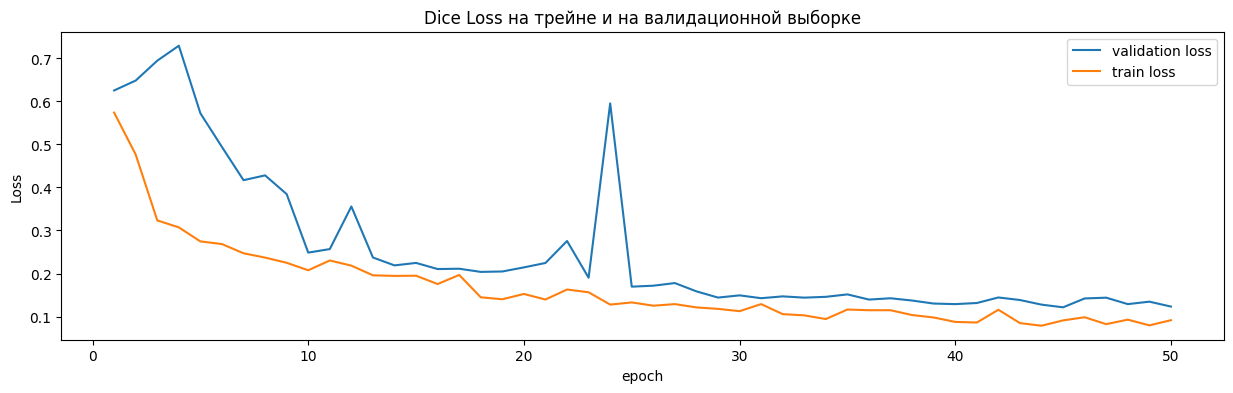

In [ ]:
plt.plot(range(1, 51), score_dice['val_loss'], label='validation loss')
plt.plot(range(1, 51), score_dice['train_loss'], label='train loss')


plt.title('Dice Loss на трейне и на валидационной выборке')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()

In [ ]:
model_focal = SegNet()
criterion = lambda logits, labels: sigmoid_focal_loss(logits, labels, reduction='none').mean()
optimizer = torch.optim.Adam(model_focal.parameters(), lr = 1e-3)
model_focal, score_focal = train_func(model_focal, 50, loaders, optimizer, criterion)

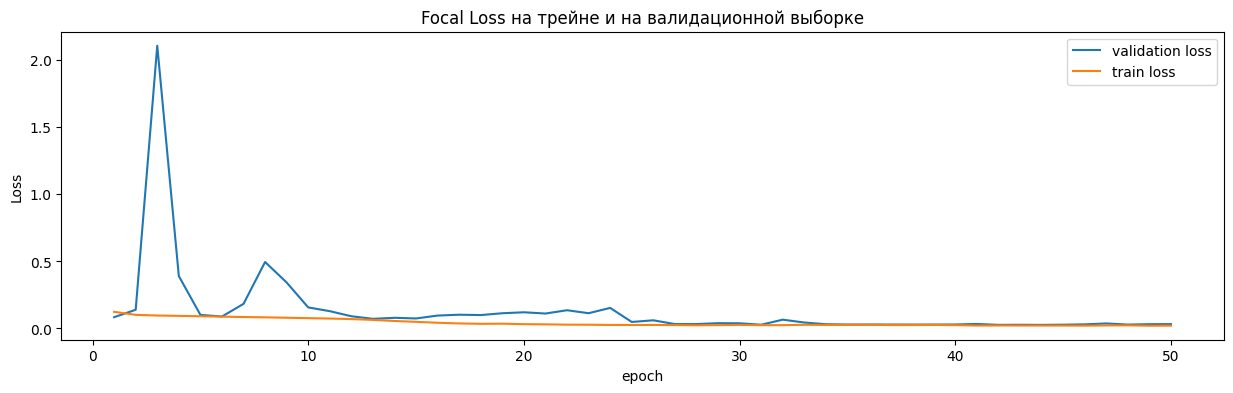

In [ ]:
plt.plot(range(1, 51), score_focal['val_loss'], label='validation loss')
plt.plot(range(1, 51), score_focal['train_loss'], label='train loss')

plt.title('Focal Loss на трейне и на валидационной выборке')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()

In [ ]:
model_ssl = SegNet()
ssloss = BinaryStructuralSimilarityLoss()
criterion = lambda logits, labels: ssloss(logits, labels).mean()
optimizer = torch.optim.Adam(model_ssl.parameters(), lr = 1e-3)
model_ssl, score_ssl = train_func(model_ssl, 50, loaders, optimizer, criterion)

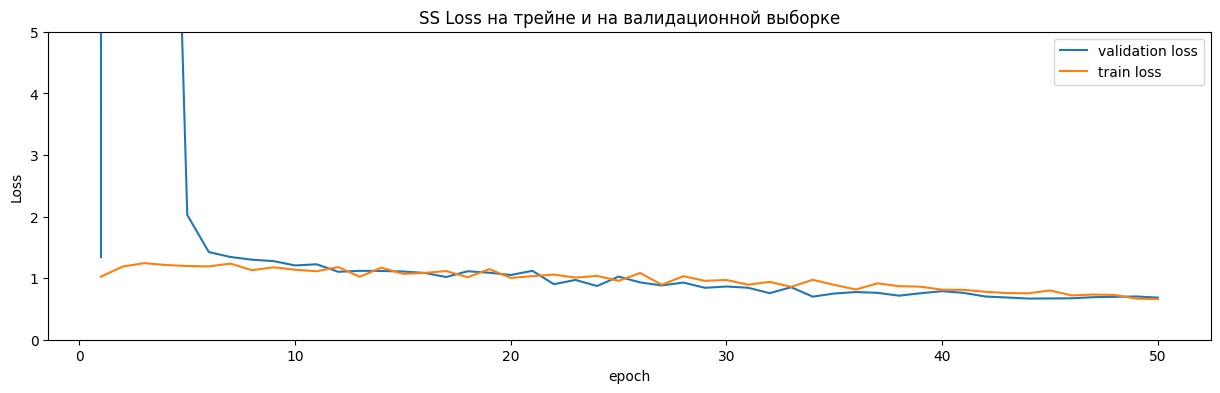

In [ ]:
plt.plot(range(1, 51), score_ssl['val_loss'], label='validation loss')
plt.plot(range(1, 51), score_ssl['train_loss'], label='train loss')

plt.ylim(0, 5)

plt.title('SS Loss на трейне и на валидационной выборке')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()

Сущий кошмар.......... Никакого обучения на этом лоссе не происходит(((

In [ ]:
test_dice = test(model_dice, test_dataloader)
test_focal = test(model_focal, test_dataloader)
test_ssl = test(model_ssl, test_dataloader)
test_baseline = test(model_baseline, test_dataloader)

In [ ]:
print("Модель с BCE Loss имеет Iou:", test_baseline.item())
print("Модель с Dice Loss имеет Iou:", test_dice.item())
print("Модель с Focal Loss имеет Iou:", test_focal.item())
print("Модель с SS Loss имеет Iou:", test_ssl.item())

Модель с BCE Loss имеет Iou: 0.8155158758163452
Модель с Dice Loss имеет Iou: 0.8225172758102417
Модель с Focal Loss имеет Iou: 0.7644078731536865
Модель с SS Loss имеет Iou: 0.0


Очень важно сказать, что результаты сильно зависят от запуска, но в основном bce всегда в отличном состоянии. Следующим по качеству идет Dice и Focal. SSL всегда ужасен)

Наилучшую сходимость показали dice и bce. Однако bce более стабильный.

Наилучшую метрику на тесте выдал Dicе.

# Задание: Новая модель!

## Модель U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

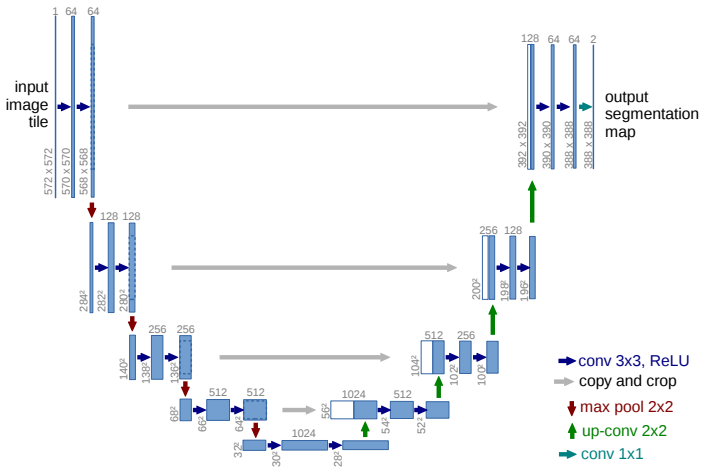

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

В оригинальной статье авторы не использовали padding внутри модели (это видно по тому, что размеры карты признаков уменьшаются на 2 каждый раз при движении от слоя к слою). При этом размеры входных изображений авторы единоразово увеличили при помощи mirror padding.

В этом домашнем задании вы можете применить альтернативный подход - сохранять размеры карт признаков при помощью padding = 1 во внутренних слоях.  

In [ ]:
import torch.nn.functional as F
import torch.nn as nn

Для реализации UNet вы можете написать классы блоков энкодера и декодера отдельно, как мы сделали при реализации SegNet.

Я делала так, как предлагают в статье — без батч-нормализации.

In [ ]:
class UNetEncoder(nn.Module):
  def __init__(self, in_channels, out_channels, do_pool=True):
    super().__init__()

    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
    )

    self.do_pool = do_pool
    if do_pool: # для botleneck'а пулинг не нужен
      self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

  def forward(self, x):
    x_conv = self.conv(x)
    if self.do_pool:
      x_down = self.pool(x_conv)
      return x_conv, x_down
    else:
      return x_conv

In [ ]:
class UNetDecoder(nn.Module):
  def __init__(self, in_channels, out_channels, padding=1):
    super().__init__()

    self.up_conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    self.conv = nn.Sequential(
        nn.Conv2d(out_channels * 2, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
    )

  def forward(self, x, skip):
    x = self.up_conv(x)
    x = torch.cat([skip, x], dim=1)
    return self.conv(x)

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_class=1):
        super().__init__()

        self.e0 = UNetEncoder(3, 64)
        self.e1 = UNetEncoder(64, 128)
        self.e2 = UNetEncoder(128, 256)
        self.e3 = UNetEncoder(256, 512)
        self.e4 = UNetEncoder(512, 1024, do_pool=False)

        self.d0 = UNetDecoder(1024, 512)
        self.d1 = UNetDecoder(512, 256)
        self.d2 = UNetDecoder(256, 128)
        self.d3 = UNetDecoder(128, 64)

        self.final_conv = nn.Conv2d(64, n_class, kernel_size=1)

    def forward(self, x):
        x0_conv, x0_down = self.e0(x)
        x1_conv, x1_down = self.e1(x0_down)
        x2_conv, x2_down = self.e2(x1_down)
        x3_conv, x3_down = self.e3(x2_down)
        x4_conv = self.e4(x3_down)

        x = self.d0(x4_conv, x3_conv)
        x = self.d1(x, x2_conv)
        x = self.d2(x, x1_conv)
        x = self.d3(x, x0_conv)

        output = self.final_conv(x)
        return output

## Обучите UNet

Задание: обучите UNet на всех трех лоссах: BCE, Dice, Focal и сравните результаты с SegNet:
*   Какая модель дает лучшие значения по метрике?
*   Какая модель дает лучшие значения по лоссам?
*   Какая модель обучается быстрее?
*   Сравните визуально результаты SegNet и UNet.

Напишите развернутый ответ на вопросы.



1. Обучим U-Net на Focal Loss

In [ ]:
unet_model_focal = UNet().to(DEVICE)
criterion = lambda logits, labels: sigmoid_focal_loss(logits, labels, reduction='none').mean()
optimizer = torch.optim.Adam(unet_model_focal.parameters(), lr = 1e-3)
unet_model_focal, unet_score_focal = train_func(unet_model_focal, 50, loaders, optimizer, criterion)

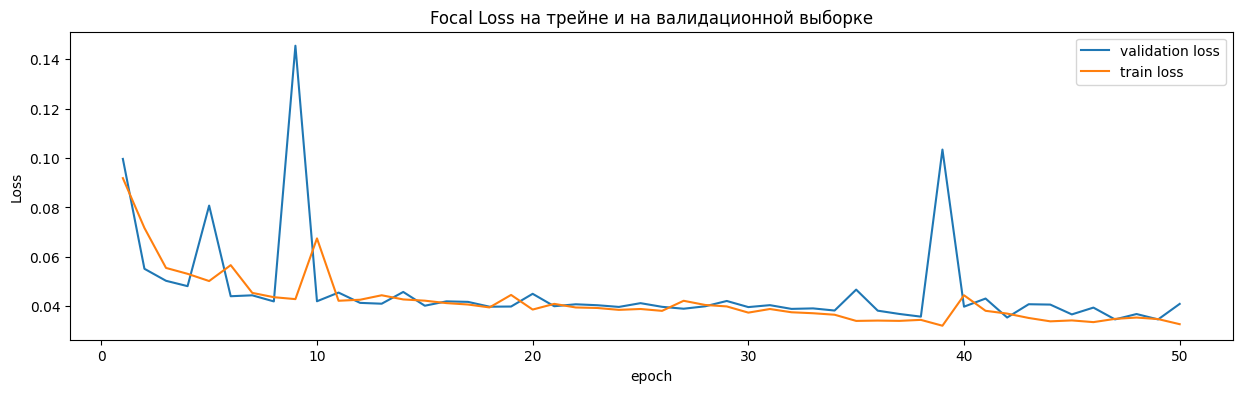

In [ ]:
plt.plot(range(1, 51), unet_score_focal['val_loss'], label='validation loss')
plt.plot(range(1, 51), unet_score_focal['train_loss'], label='train loss')


plt.title('Focal Loss на трейне и на валидационной выборке')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()

2. Обучим U-Net на Dice Loss

In [ ]:
unet_model_dice = UNet().to(DEVICE)
criterion = lambda logits, labels: dice_loss(logits, labels).mean()
optimizer = torch.optim.Adam(unet_model_dice.parameters(), lr = 3e-4)
unet_model_dice, unet_score_dice = train_func(unet_model_dice, 50, loaders, optimizer, criterion)

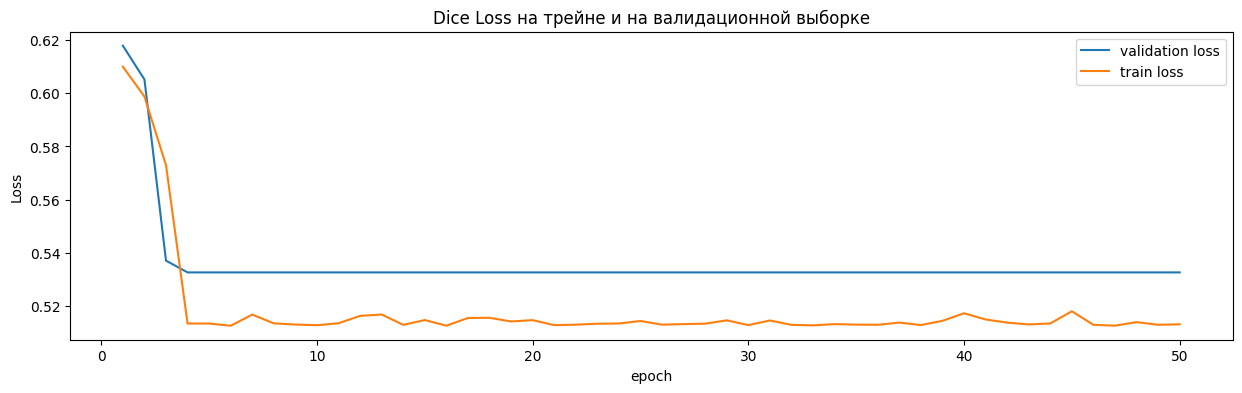

In [ ]:
plt.plot(range(1, 51), unet_score_dice['val_loss'], label='validation loss')
plt.plot(range(1, 51), unet_score_dice['train_loss'], label='train loss')


plt.title('Dice Loss на трейне и на валидационной выборке')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()

2. Обучим U-Net на BCE Loss

In [ ]:
unet_model_bce = UNet().to(DEVICE)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(unet_model_bce.parameters(), lr = 1e-3)
unet_model_bce, unet_score_bce = train_func(unet_model_bce, 50, loaders, optimizer, criterion)

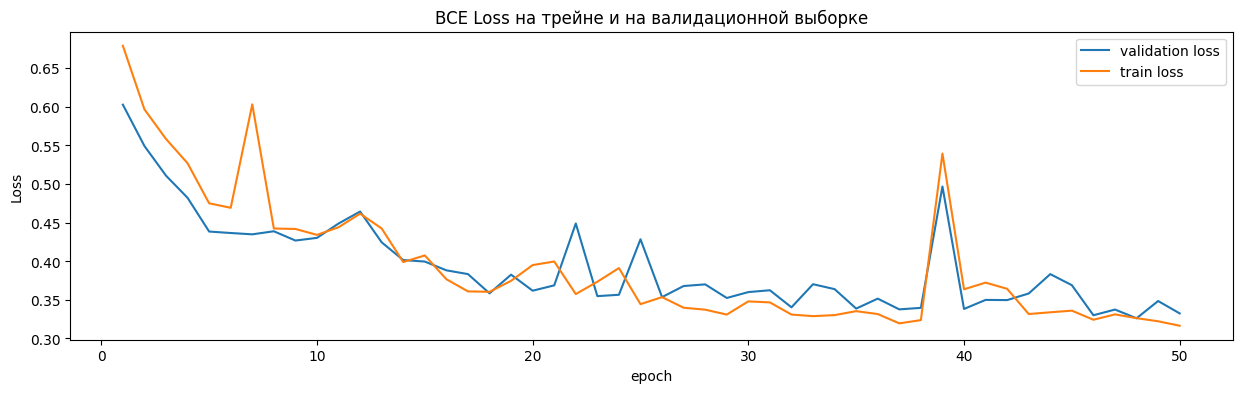

In [ ]:
plt.plot(range(1, 51), unet_score_bce['val_loss'], label='validation loss')
plt.plot(range(1, 51), unet_score_bce['train_loss'], label='train loss')


plt.title('BCE Loss на трейне и на валидационной выборке')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()

In [ ]:
test_unet_dice = test(unet_model_dice, test_dataloader)
test_unet_focal = test(unet_model_focal, test_dataloader)
test_unet_bce = test(unet_model_bce, test_dataloader)

In [ ]:
print("Модель с Dice Loss имеет Iou:", test_unet_dice.item())
print("Модель с Focal Loss имеет Iou:", test_unet_focal.item())
print("Модель с BCE Loss имеет Iou:", test_unet_bce.item())

Модель с Dice Loss имеет Iou: 0.3411077857017517
Модель с Focal Loss имеет Iou: 0.516905665397644
Модель с BCE Loss имеет Iou: 0.5998325347900391


**Какая модель дает лучшие значения по метрике?**

Ответ: Определенно SegNet. Для сравнения результаты на тестовой выборке:
* SegNet
    * Модель с BCE Loss имеет Iou: 0.8155158758163452
    * Модель с Dice Loss имеет Iou: 0.8225172758102417
    * Модель с Focal Loss имеет Iou: 0.7644078731536865
* U-Net
    * Модель с BCE Loss имеет Iou: 0.5998325347900391
    * Модель с Dice Loss имеет Iou: 0.3454821705818176
    * Модель с Focal Loss имеет Iou: 0.516905665397644

**Какая модель дает лучшие значения по лоссам?**

Ответ: по этому критерию моедли очень похожи. Однако для Dice U-Net с какого-то момента перестала обучаться и лосс был большим.

**Какая модель обучается быстрее?**

Ответ: обе модели с 10-15 эпохи выходили на достаточно маленькую ошибку. Но судя по метрике SegNet получал хороший результат на 10 эпохе, а U-Net только на 20.

**Сравните визуально результаты SegNet и UNet.**

Визуальное сравнение представлено в блоках ниже. Сильно заметно, что U-Net обучается очень не стабильно - сильными скачками, а также качество обучения намного хуже

### 1. IoU на валидационной выборке для модели SegNet

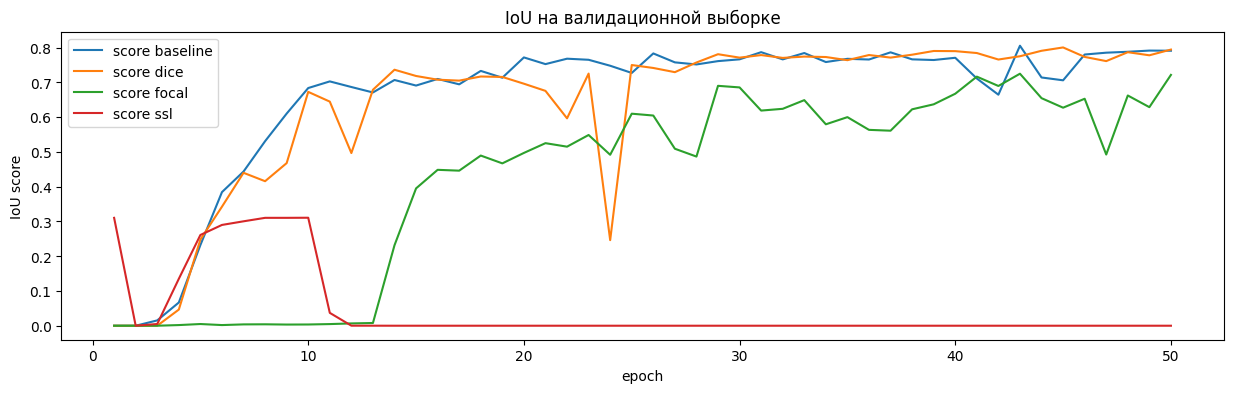

In [ ]:
plt.plot(range(1, 51), score_baseline['val_iou'], label='score baseline')
plt.plot(range(1, 51), score_dice['val_iou'], label='score dice')
plt.plot(range(1, 51), score_focal['val_iou'], label='score focal')
plt.plot(range(1, 51), score_ssl['val_iou'], label='score ssl')


plt.title('IoU на валидационной выборке')
plt.xlabel('epoch')
plt.ylabel('IoU score')
plt.legend()

### 2. IoU на валидационной выборке для модели U-Net

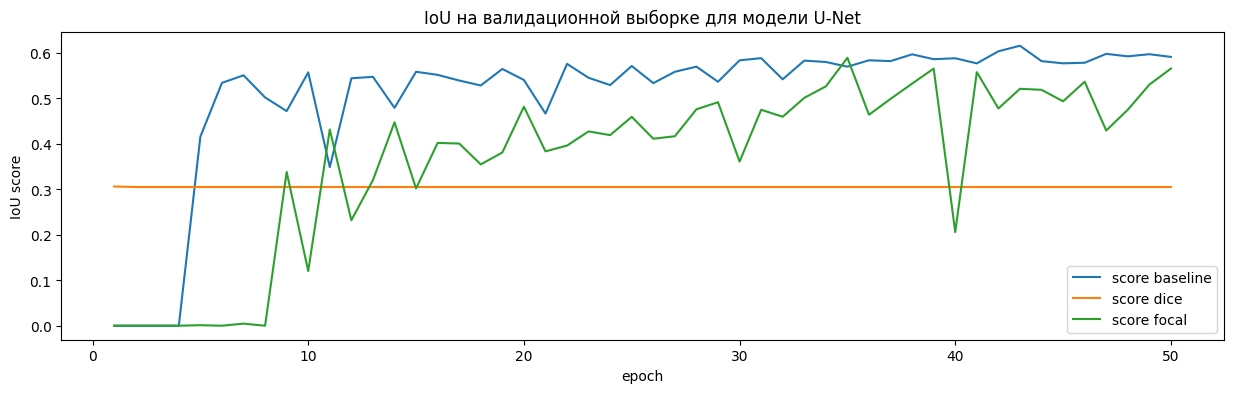

In [ ]:
plt.plot(range(1, 51), unet_score_bce['val_iou'], label='score baseline')
plt.plot(range(1, 51), unet_score_dice['val_iou'], label='score dice')
plt.plot(range(1, 51), unet_score_focal['val_iou'], label='score focal')

plt.title('IoU на валидационной выборке для модели U-Net')
plt.xlabel('epoch')
plt.ylabel('IoU score')
plt.legend()